In [37]:
url = 'https://anaconda.org/conda-forge/libta-lib/0.4.0/download/linux-64/libta-lib-0.4.0-h166bdaf_1.tar.bz2'
!curl -L $url | tar xj -C /usr/lib/x86_64-linux-gnu/ lib --strip-components=1
url = 'https://anaconda.org/conda-forge/ta-lib/0.4.19/download/linux-64/ta-lib-0.4.19-py310hde88566_4.tar.bz2'
!curl -L $url | tar xj -C /usr/local/lib/python3.10/dist-packages/ lib/python3.10/site-packages/talib --strip-components=3
import talib

  % Total    % Received % Xferd  Average Speed   Time    Time     Time  Current
                                 Dload  Upload   Total   Spent    Left  Speed
100  4453    0  4453    0     0  10364      0 --:--:-- --:--:-- --:--:-- 10379
100  517k  100  517k    0     0   396k      0  0:00:01  0:00:01 --:--:-- 1017k
  % Total    % Received % Xferd  Average Speed   Time    Time     Time  Current
                                 Dload  Upload   Total   Spent    Left  Speed
100  4489    0  4489    0     0  18395      0 --:--:-- --:--:-- --:--:-- 18473
100  392k  100  392k    0     0   348k      0  0:00:01  0:00:01 --:--:--  549k


In [38]:
!pip install empyrical

In [39]:
import warnings
warnings.filterwarnings("ignore")
import pandas as pd
import numpy as np
import talib
import math
from empyrical import max_drawdown, sharpe_ratio

In [40]:
df = pd.read_csv('btcusdt_1h.csv')
n=26
df['ma'] = df['close'].rolling(window=10).mean()
df['Change'] = abs(df['close'] - df['close'].shift(10))
df['Volatility'] = abs(df['close'] - df['close'].shift()).rolling(n).sum()
df['ER'] = df['Change']/df['Volatility']
df['SC'] = np.square(df['ER']*(2.0/(2+1)-2.0/(30+1))+2.0/(30+1))
df['KAMA'] = df['close'].rolling(n).mean()
df['KAMA'][:n]= np.nan

i = 1
while i<len(df['KAMA'][n+1:]):
        s = df['KAMA']
        s.iloc[n+i] = df['KAMA'][n+i-1] + df['SC'][n+i]*(df['close'][n+i] - df['KAMA'][n+i-1])
        df['KAMA'] = s
        i = i + 1
df = df.drop(['Change','Volatility','ER','SC'],axis=1)
df['MACD_KAMA'] = df['KAMA'].ewm(span=12,adjust=False).mean() - df['KAMA'].ewm(span=26,adjust=False).mean()
df['signal_line'] = df['MACD_KAMA'].rolling(window = 9).mean()

In [41]:
def rsi(df, period=14):
    df['rsi'] = talib.RSI(df['close'], period)
    return df
df = rsi(df)

In [42]:
df

,datetime,open,high,low,close,volume,ma,KAMA,MACD_KAMA,signal_line,rsi
0,2018-01-01 05:30:00,13715.65,13715.65,13400.01,13529.01,443.356199,NaN,NaN,NaN,NaN,NaN
1,2018-01-01 06:30:00,13528.99,13595.89,13155.38,13203.06,383.697006,NaN,NaN,NaN,NaN,NaN
2,2018-01-01 07:30:00,13203.00,13418.43,13200.00,13330.18,429.064572,NaN,NaN,NaN,NaN,NaN
3,2018-01-01 08:30:00,13330.26,13611.27,13290.00,13410.03,420.087030,NaN,NaN,NaN,NaN,NaN
4,2018-01-01 09:30:00,13434.98,13623.29,13322.15,13601.01,340.807329,NaN,NaN,NaN,NaN,NaN
...,...,...,...,...,...,...,...,...,...,...,...
35203,2022-01-12 01:30:00,42972.04,43095.26,42692.19,42800.38,1219.601780,42248.181,42099.915660,-21.105229,-39.372333,62.352113
35204,2022-01-12 02:30:00,42797.62,42823.69,42643.74,42659.20,702.103800,42333.102,42115.954509,-13.807886,-35.213692,59.368552
35205,2022-01-12 03:30:00,42664.71,42776.14,42597.41,42713.13,561.859930,42423.146,42136.309311,-6.309495,-30.527016,60.152924
35206,2022-01-12 04:30:00,42713.12,42886.28,42633.97,42729.29,681.142010,42525.923,42160.298356,1.550871,-25.206239,60.399616


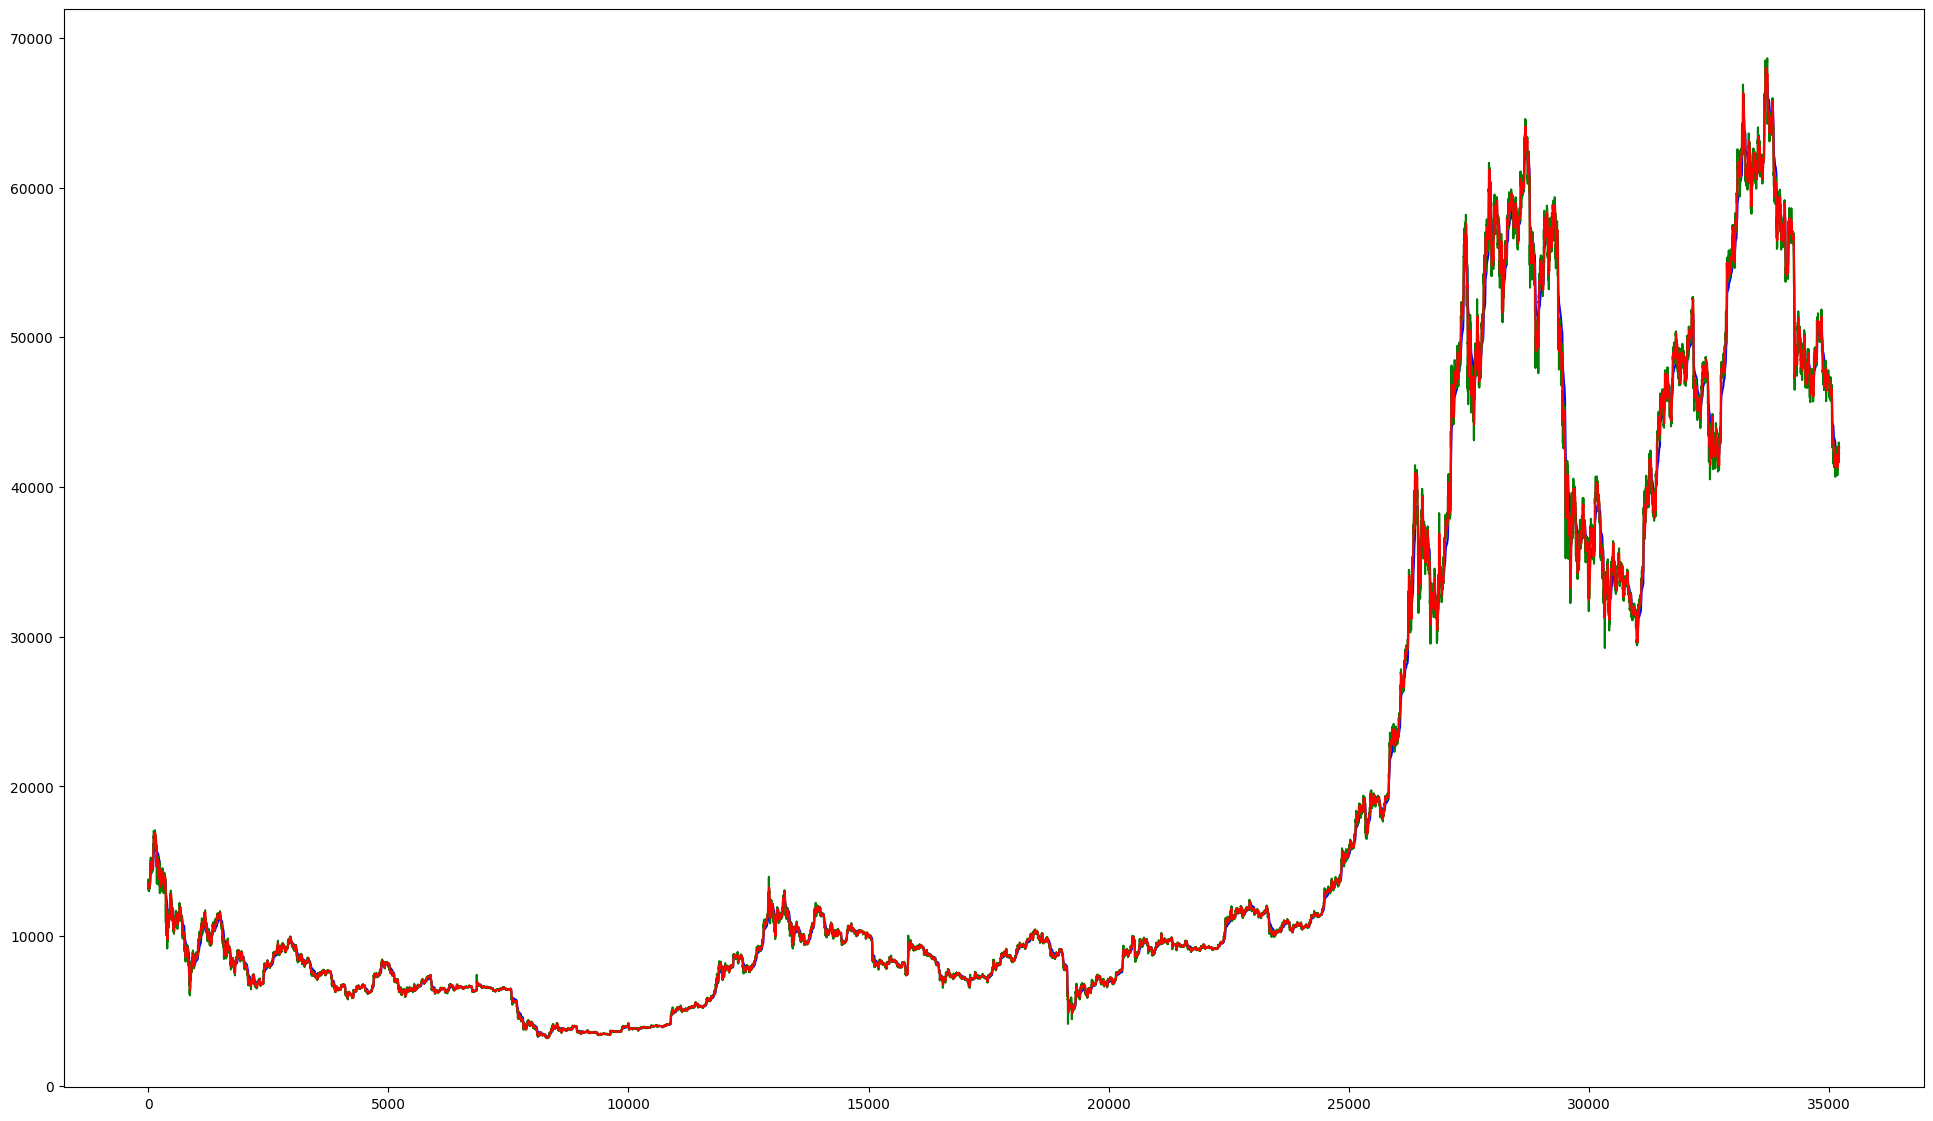

In [43]:
import matplotlib.pyplot as plt
plt.figure(figsize = (24,14))
plt.plot(df['KAMA'], color = 'blue')
plt.plot(df['close'], color = 'green')
plt.plot(df['ma'],color = 'red')
plt.show()

In [44]:
df['MACD_KAMA'] = df['KAMA'].ewm(span=12,adjust=False).mean() - df['KAMA'].ewm(span=26,adjust=False).mean()
df['signal_line'] = df['MACD_KAMA'].rolling(window = 9).mean()

In [45]:
df['signals'] = 0
flag = 0
for i in range(len(df)):
    if df.MACD_KAMA[i] > df.signal_line[i] and df.rsi[i]>70 :
        df.signals[i] = 1
        flag = 1
    elif df.MACD_KAMA[i] < df.signal_line[i] and df.rsi[i]<30:
        df.signals[i] = -1
        flag = 0

In [46]:
df

,datetime,open,high,low,close,volume,ma,KAMA,MACD_KAMA,signal_line,rsi,signals
0,2018-01-01 05:30:00,13715.65,13715.65,13400.01,13529.01,443.356199,NaN,NaN,NaN,NaN,NaN,0
1,2018-01-01 06:30:00,13528.99,13595.89,13155.38,13203.06,383.697006,NaN,NaN,NaN,NaN,NaN,0
2,2018-01-01 07:30:00,13203.00,13418.43,13200.00,13330.18,429.064572,NaN,NaN,NaN,NaN,NaN,0
3,2018-01-01 08:30:00,13330.26,13611.27,13290.00,13410.03,420.087030,NaN,NaN,NaN,NaN,NaN,0
4,2018-01-01 09:30:00,13434.98,13623.29,13322.15,13601.01,340.807329,NaN,NaN,NaN,NaN,NaN,0
...,...,...,...,...,...,...,...,...,...,...,...,...
35203,2022-01-12 01:30:00,42972.04,43095.26,42692.19,42800.38,1219.601780,42248.181,42099.915660,-21.105229,-39.372333,62.352113,0
35204,2022-01-12 02:30:00,42797.62,42823.69,42643.74,42659.20,702.103800,42333.102,42115.954509,-13.807886,-35.213692,59.368552,0
35205,2022-01-12 03:30:00,42664.71,42776.14,42597.41,42713.13,561.859930,42423.146,42136.309311,-6.309495,-30.527016,60.152924,0
35206,2022-01-12 04:30:00,42713.12,42886.28,42633.97,42729.29,681.142010,42525.923,42160.298356,1.550871,-25.206239,60.399616,0


In [47]:
class TradingStrategy:

    '''This function initializes the class according to the data provided, it creates several variables for inside the class, as described'''
    def __init__(self, data):

        self.capital = 1000 # this represents the current capital
        self.data = data # this variable is created to use the data inside each function of the class

        self.datetime = [] # datetime colmun, it is for daily trade log, will remain same as in data originally

        self.portfolio_value = [] # this is the portfolio value we have at each index (each day)
        self.quantity = [] # this represents the holding at each index (each day)
        self.current_position = 0 # this represents the current position (-1 = short, 1 = long, 0 = no position)
        self.holding = 0 # this represents the current holding (will be updated at each index)

        self.current_portfolio_value = 0 # this represents the current portfolio value (will be updated at each index)

        self.current_stop_loss_value = 0 # this is the temporary variable for the trade in action
        self.current_trade_peak = 0 # this is the maximum portfolio value for trade in action (as we implemented trailing stop-loss)
        self.stop_loss_percent = 0.071 # this is the stop-loss percentage (can be changed as per requirement)

        self.take_profit_value = 0 # this is the temporary variable for the trade in action
        self.take_profit_percent = 1000 # this is the take-profit percentage (can be changed as per requirement)

        self.stop_loss_count = [] # this variable is for the count of number of trades exited because of stop-loss
        self.take_profit_count = [] # this variable is for the count of number of trades exited because of take profit

        self.entry = [] # list to store entry index of each trade
        self.exit = [] # list to store exit index of each trade
        self.new_signals = [] # list to new signals, after implementation of stop loss and take profit, and if required, other exit conditions
        self.close = data['close'] # close value of btc-usdt

        self.trade_type = [] # this is for trade type, according to entry type
        self.drawdown = [] # this is drawdown for each day
        self.benchmark_return = (((1000/self.close[0]) * self.close[len(self.data) - 1] - 1000)) # this is benchmark returns, according to buy & hold

        self.signals = data['signals'] # signals column according to strategy
        self.transaction_percentage = 0.0015

        self.risk_free_rate = 0.05 # you can change it

        self.amount_in_trade = []

        self.trade_wise_returns = []
        self.PL_in_dollars = []

        self.amount_invested_in_trade = []

    '''This is the function to calculate drawdown, it returns an array of drawdown according to portolio value,
     for maximum drawdown, we will take maximum of this drawdown array'''
    def calculate_drawdown(self):
        data = self.portfolio_value
        drawdown = []
        temp_peak = data[0]
        for i in range(len(data)):
            if data[i] > temp_peak:
                temp_peak = data[i]
            drawdown.append(-((temp_peak - data[i])/temp_peak) * 100)
        return drawdown

    '''This function is used to start a long position on the equity'''
    def take_long_position(self,i):
        self.current_position = 1
        self.holding = self.capital / self.close[i] # as we buy the equity from all the capital we posses
        self.capital = 0
        self.new_signals.append(1)
        self.quantity.append(self.holding)
        self.current_portfolio_value = self.holding * self.close[i]
        self.portfolio_value.append(self.current_portfolio_value)
        self.entry.append(i)
        self.trade_type.append('long')
        self.amount_in_trade.append(self.current_portfolio_value)
        self.amount_invested_in_trade.append(self.current_portfolio_value)

    '''This function is used to start a short position on the equity'''
    def take_short_position(self,i):
        self.current_position = -1
        self.holding = self.capital / self.close[i]
        self.capital = 2 * self.capital
        self.new_signals.append(-1)
        self.quantity.append(self.holding)
        self.current_portfolio_value = self.capital - self.holding * self.close[i]
        self.portfolio_value.append(self.current_portfolio_value)
        self.entry.append(i)
        self.trade_type.append('short')
        self.amount_in_trade.append(self.current_portfolio_value)
        self.amount_invested_in_trade.append(self.current_portfolio_value)

    '''This function is called when we currently have no position, and do not intend to start either. So portfolio value will be same as capital'''
    def update_no_trade(self,i):
        self.current_position = 0
        self.new_signals.append(0)
        self.holding = 0
        self.portfolio_value.append(self.capital)
        self.quantity.append(0)

    '''This function is called when we are currently on long, and we don't want to exit the trade,so current holding and capital remain same'''
    def update_long_trade(self, i):
        self.current_position = 1
        self.quantity.append(self.holding)
        self.current_portfolio_value = self.holding * self.close[i]
        self.portfolio_value.append(self.current_portfolio_value)
        self.new_signals.append(0)

    '''This function is called when we are currently on short, and we don't want to exit the trade,so current holding and capital remain same'''
    def update_short_trade(self, i):
        self.current_position = -1
        self.quantity.append(self.holding)
        self.current_portfolio_value = self.capital - self.holding * self.close[i]
        self.portfolio_value.append(self.current_portfolio_value)
        self.new_signals.append(0)

    '''This function is called when we want to exit a long trade, so we will increase in hand capital in this case'''
    def close_long_trade(self, i):
        self.current_position = 0
        self.quantity.append(0)
        self.capital = self.close[i] * self.holding
        self.current_portfolio_value = self.capital
        self.portfolio_value.append(self.current_portfolio_value)
        self.new_signals.append(-1)
        self.exit.append(i)
        self.amount_in_trade.append(self.current_portfolio_value)

    '''This function is called when we want to exit a short trade, so we will increase in hand capital in this case'''
    def close_short_trade(self, i):
        self.current_position = 0
        self.capital = self.capital - self.close[i] * self.holding
        self.quantity.append(0)
        self.current_portfolio_value = self.capital
        self.portfolio_value.append(self.current_portfolio_value)
        self.new_signals.append(1)
        self.exit.append(i)
        self.amount_in_trade.append(self.current_portfolio_value)

    '''This function is called when we are currently on long/short position. It checks if we should exit the trade based on stop-loss and take-profit'''
    def check_exit_condition(self, i):
        if self.current_position == 1:
            temp_value = self.holding * self.close[i]
            if temp_value < self.current_stop_loss_value:
                self.stop_loss_count.append(i)
                return 1
            elif temp_value >= self.take_profit_value:
                self.take_profit_count.append(i)
                return 1
        elif self.current_position == -1:
            temp_value = self.capital - self.holding * self.close[i]
            if temp_value > self.current_stop_loss_value:
                self.stop_loss_count.append(i)
                return 1
            elif temp_value <= self.take_profit_value:
                self.take_profit_count.append(i)
                return 1
        return 0

    '''This function is to set the stop-loss depending on entry price'''
    def set_stop_loss(self, i):
        if self.current_position == 1:
            self.current_stop_loss_value = (1 - self.stop_loss_percent) * (self.current_trade_peak)
        elif self.current_position == -1:
            self.current_stop_loss_value = (1 + self.stop_loss_percent) * (self.current_trade_peak)

    '''This function is used to update the stop-loss value, if the portfolio value increases (TRAILING STOP-LOSS)'''
    def update_stop_loss(self, i):
        if self.current_position == 1:
            if self.holding * self.close[i] > self.current_trade_peak:
                self.current_trade_peak = self.holding * self.close[i]
                self.set_stop_loss(i)
        elif self.current_position == -1:
            if self.capital - self.holding * self.close[i] < self.current_trade_peak:
                self.current_trade_peak = self.capital - self.holding * self.close[i]
                self.set_stop_loss(i)

    '''This function is to set the take-profit depending on entry price'''
    def set_take_profit(self, i):
        if self.current_position == 1:
            self.take_profit_value = (1 + self.take_profit_percent) * (self.current_portfolio_value)
        elif self.current_position == -1:
            self.take_profit_value = (1 - self.take_profit_percent) * (self.current_portfolio_value)

    '''This is the function, which when called will analyse all the trades'''
    def compounding(self):

        x = len(self.data) - 1 # we don't care about the signal on last date, because we cannot open anew position, and if a position is already open, we must close it
        for i in range(x):
            self.datetime.append(self.data.datetime[i])
            if self.capital < 0: # this possibility may arise in compounding approach
                print('capital wiped')

            if self.current_position == 0:

                if self.signals[i] == 0:
                    self.update_no_trade(i)
                elif self.signals[i] == 1:
                    self.take_long_position(i) # to start a new long position
                    self.current_trade_peak = self.current_portfolio_value
                    self.set_take_profit(i)
                    self.set_stop_loss(i)
                elif self.signals[i] == -1:
                    self.take_short_position(i) # to start a new short position
                    self.current_trade_peak = self.current_portfolio_value
                    self.set_take_profit(i)
                    self.set_stop_loss(i)

            elif self.current_position == 1:
                if self.signals[i] == 0 or self.signals[i] == 1:
                    if self.check_exit_condition(i) == 1:
                        self.close_long_trade(i) # to close a long position
                    else:
                        self.update_stop_loss(i)
                        self.update_long_trade(i)
                else:
                    self.close_long_trade(i) # to close a long position

            elif self.current_position == -1:
                if self.signals[i] == 0 or self.signals[i] == -1:
                    if self.check_exit_condition(i) == 1:
                        self.close_short_trade(i) # to close a short position
                    else:
                        self.update_stop_loss(i)
                        self.update_short_trade(i)
                else:
                    self.close_short_trade(i) # to close a short position

        # for the last trade
        self.datetime.append(self.data.datetime[x])

        if self.current_position == 1:
            self.close_long_trade(x)
        elif self.current_position == -1:
            self.close_short_trade(x)
        else:
            self.update_no_trade(i)

        '''''''''''''''''''''''''''''''''''''''''''''''Trade log completed'''''''''''''''''''''''''''''''''''''''''''''''
        # we now calculate the remaining parameters like trade-wise profit/loss, max drawdown, net pnl. This is purely maths as we already have our portfolio vlaue for each day stored

        self.trade_wise_duration = np.array(self.exit) - np.array(self.entry)
        self.trade_wise_profit = []
        self.trade_wise_loss = []

        for i in range(len(self.entry)):
            current_trade_return = 100*((self.portfolio_value[self.exit[i]]/self.portfolio_value[self.entry[i]])-1)
            self.PL_in_dollars.append(self.portfolio_value[self.exit[i]]-self.portfolio_value[self.entry[i]])
            self.trade_wise_returns.append(current_trade_return)
            if current_trade_return >= 0:
                self.trade_wise_profit.append(current_trade_return)
            else:
                self.trade_wise_loss.append(current_trade_return)

        self.gross_profit = np.sum(self.PL_in_dollars)
        self.calculate_transaction_cost()
        self.net_profit = self.gross_profit - self.transaction_cost
        self.returns = self.net_profit / 10
        self.drawdown = self.calculate_drawdown()
        self.calculate_ratios()
        '''''''''''''''''''''''''''''''''''''''''''''''All parameters calculated'''''''''''''''''''''''''''''''''''''''''''''''

        self.print_parameters()
        return self.create_strategy_dataframes() , self.create_trade_wise_dataframe() , self.create_every_day_dataframe()


    def calculate_ratios(self):
        df = pd.DataFrame()
        df['portfolio_value'] = self.portfolio_value
        df['daily_return'] = df['portfolio_value'].pct_change()
        daily_volatility = df['daily_return'].std()
        annual_volatility = daily_volatility * math.sqrt(365)
        annual_volatility_negative = df[df['daily_return'] < 0]['daily_return'].std() * math.sqrt(365)
        risk_free_rate = self.risk_free_rate
        df['excess_return'] = (df['daily_return'] - risk_free_rate)
        annual_excess_return = (df['daily_return'].mean()*365 - risk_free_rate)
        cumulative_excess_return = df['excess_return'].sum()
        negative_returns = [r for r in df['excess_return'] if r < 0]
        cumulative_volatility = df['daily_return'].std()*math.sqrt(365)
        x = np.std(negative_returns)*math.sqrt(365)
        self.sharpe_ratio = annual_excess_return / annual_volatility
        self.sortino_ratio = annual_excess_return / annual_volatility_negative


    def calculate_transaction_cost(self):
        self.transaction_cost = 0
        for i in range(len(self.entry)):
            self.transaction_cost += self.transaction_percentage * (self.amount_invested_in_trade[i])

    '''After backtesting is complete, this function generated a dataframe which is the final one, after take-profit and stop-loss is implemented'''
    def create_strategy_dataframes(self):
        to_submit = pd.DataFrame(columns=['datetime'])
        to_submit['datetime'] = self.datetime
        to_submit['open'] = self.data.open
        to_submit['high'] = self.data.high
        to_submit['low'] = self.data.low
        to_submit['close'] = self.data.close
        to_submit['volume'] = self.data.volume
        to_submit['signals'] = self.new_signals
        return to_submit

    '''This function generated a trade-log for our strategy, giving returns in each trade'''
    def create_trade_wise_dataframe(self):
        trade_wise = pd.DataFrame(columns=['entry', 'exit'])
        trade_wise['entry'] = self.entry
        trade_wise['exit'] = self.exit
        trade_wise['duration'] = self.trade_wise_duration
        trade_wise['trade type'] = self.trade_type
        trade_wise['returns'] = self.trade_wise_returns
        return trade_wise

    '''This function creates and everyday log of our strategy, to analyze the portfolio value and drawdown for each day'''
    def create_every_day_dataframe(self):
        every_day = pd.DataFrame(columns=['datetime', 'portfolio value', 'quantity'])
        every_day['datetime'] = self.datetime
        every_day['quantity'] = self.quantity
        every_day['portfolio value'] = self.portfolio_value
        every_day['daily_return'] = every_day['portfolio value'].pct_change()
        every_day['drawdown'] = self.drawdown
        return every_day

    '''This function is used to print the necassary parameters, useful for analyzing our strategy'''
    def print_parameters(self):
        plt.subplot(2, 1, 1)
        plt.plot(self.portfolio_value)
        plt.title('Portfolio Value')

        plt.subplot(2, 1, 2)
        plt.plot(self.drawdown, color = 'r')
        plt.title('Drawdown')

        plt.tight_layout()

        print('Number of closed trade:',len(self.entry))
        print('Winning trades:',len(self.trade_wise_profit))
        print('Losing trades:',len(self.trade_wise_loss))
        print('Benchmark returns:',self.benchmark_return)
        print('Win rate:',(len(self.trade_wise_profit)/len(self.entry))*100)
        print('Maximum drawdown:',np.min(self.drawdown))
        print('Largest win:',np.max(self.trade_wise_profit))
        print('Average win:',np.mean(self.trade_wise_profit))
        print('Largest loss:',np.min(self.trade_wise_loss))
        print('Average loss:',np.mean(self.trade_wise_loss))
        print('Maximum holding time:',np.max(self.trade_wise_duration))
        print('Average holding period:',np.mean(self.trade_wise_duration))
        print('Gross Profit:',self.gross_profit)
        print('Net Profit:',self.net_profit)
        print('Returns:',self.returns,'%')
        print('Number of times stop loss met:',len(self.stop_loss_count))
        print('Number of times take profit met:',len(self.take_profit_count))

Number of closed trade: 336
Winning trades: 171
Losing trades: 165
Benchmark returns: 2154.3328004044643
Win rate: 50.89285714285714
Maximum drawdown: -40.54611685055498
Largest win: 55.89072316761854
Average win: 7.044008630849642
Largest loss: -21.753247252289498
Average loss: -4.185411454347891
Maximum holding time: 518
Average holding period: 83.97321428571429
Gross Profit: 62822.166819355916
Net Profit: 55184.42150109268
Returns: 5518.4421501092675 %
Number of times stop loss met: 157
Number of times take profit met: 0


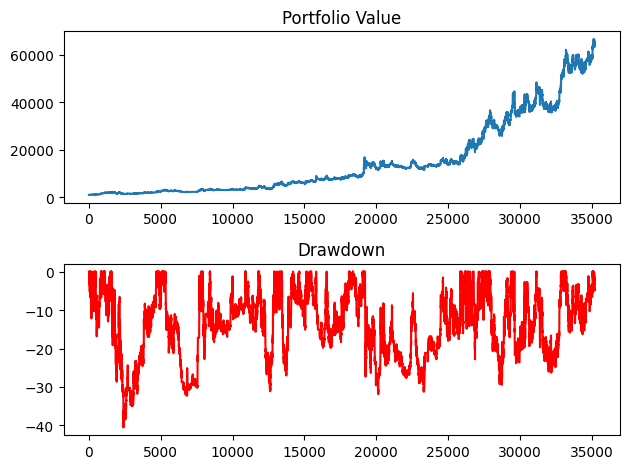

In [48]:
Testing_signals = TradingStrategy(df)
to_submit, trade_wise, every_day = Testing_signals.compounding()

In [49]:
every_day

,datetime,portfolio value,quantity,daily_return,drawdown
0,2018-01-01 05:30:00,1000.000000,0.000000,NaN,-0.000000
1,2018-01-01 06:30:00,1000.000000,0.000000,0.000000,-0.000000
2,2018-01-01 07:30:00,1000.000000,0.000000,0.000000,-0.000000
3,2018-01-01 08:30:00,1000.000000,0.000000,0.000000,-0.000000
4,2018-01-01 09:30:00,1000.000000,0.000000,0.000000,-0.000000
...,...,...,...,...,...
35203,2022-01-12 01:30:00,63642.498447,1.432991,0.003880,-4.557118
35204,2022-01-12 02:30:00,63844.808072,1.432991,0.003179,-4.253720
35205,2022-01-12 03:30:00,63767.526884,1.432991,-0.001210,-4.369616
35206,2022-01-12 04:30:00,63744.369755,1.432991,-0.000363,-4.404344


In [50]:
class TradingStrategy:

    def __init__(self, data):

        self.capital = 1000 # this represents the current capital
        self.data = data # this variable is created to use the data inside each function of the class

        self.datetime = [] # datetime colmun, it is for daily trade log, will remain same as in data originally
        self.trade_returns=[]
        self.portfolio_value = [] # this is the temporary portfolio value, which will store for a particular trade, then reset
        self.trade_wise_holding = [] # this represents the holding for each trade
        self.current_position = 0 # this represents the current position (-1 = short, 1 = long, 0 = no position)
        self.holding = 0 # this represents the current holding (temporary variable)

        self.trade_wise_final_portfolio = [] # this represents final portfolio value for each trade

        self.current_portfolio_value = 0 # this represents the current portfolio value (will be updated at each index)

        self.current_stop_loss_value = 0 # this is the temporary variable for the trade in action
        self.current_trade_peak = 0 # this is the maximum portfolio value for trade in action (as we implemented trailing stop-loss)
        self.stop_loss_percent = 0.07 # this is the stop-loss percentage (can be changed as per requirement)

        self.take_profit_value = 0 # this is the temporary variable for the trade in action
        self.take_profit_percent = 100 # this is the take-profit percentage (can be changed as per requirement)

        self.stop_loss_count = [] # this variable is for the count of number of trades exited because of stop-loss
        self.take_profit_count = [] # this variable is for the count of number of trades exited because of take profit

        self.entry = [] # list to store entry index of each trade
        self.exit = [] # list to store exit index of each trade
        self.new_signals = [] # list to new signals, after implementation of stop loss and take profit, and if required, other exit conditions
        self.close = data['close'] # close value of btc-usdt

        self.trade_type = [] # this is for trade type, according to entry type
        self.drawdown = [] # this is drawdown for each trade
        self.benchmark_return = (((1000/self.close[0]) * self.close[len(self.data) - 1] - 1000)) # this is benchmark returns, according to buy & hold

        self.signals = data['signals'] # signals column according to strategy
        # self.transaction_percentage = 0.0015
        self.transaction_cost_per_trade = []
        self.transaction_cost_in_one_trade = 1.5

        self.risk_free_rate = 0.05 # you can change it

        self.drawdown = []
        self.dip = []
        self.trade_wise_returns = []
        self.PL_in_dollars = []

    def calculate_drawdown(self):
        data = self.portfolio_value
        drawdown = []
        temp_peak = data[0]
        for i in range(len(data)):
            if data[i] > temp_peak:
                temp_peak = data[i]
            drawdown.append(-((temp_peak - data[i])/temp_peak) * 100)
        trade_max_drawdown = np.min(drawdown)
        return trade_max_drawdown

    def calculate_dip(self):
        data = self.portfolio_value
        min_portfolio_value = np.min(data)
        dip = (1000 - min_portfolio_value) / 10
        return dip

    '''This function is used to start a long position on the equity'''
    def take_long_position(self,i):
        self.capital = 1000
        self.current_position = 1
        self.holding = self.capital / self.close[i]
        self.trade_wise_holding.append(self.holding) # as we buy the equity from all the capital we posses
        self.capital = 0
        self.new_signals.append(1)
        self.current_portfolio_value = self.holding * self.close[i]
        self.portfolio_value.append(self.current_portfolio_value)
        self.entry.append(i)
        self.trade_type.append('long')

    '''This function is used to start a short position on the equity'''
    def take_short_position(self,i):
        self.capital = 1000
        self.current_position = -1
        self.holding = self.capital / self.close[i]
        self.trade_wise_holding.append(self.holding)
        self.capital = 2 * self.capital
        self.new_signals.append(-1)
        self.current_portfolio_value = self.capital - self.holding * self.close[i]
        self.portfolio_value.append(self.current_portfolio_value)
        self.entry.append(i)
        self.trade_type.append('short')

    '''This function is called when we currently have no position, and do not intend to start either. So portfolio value will be same as capital'''
    def update_no_trade(self,i):
        self.capital = 0
        self.current_position = 0
        self.new_signals.append(0)
        self.holding = 0

    '''This function is called when we are currently on long, and we don't want to exit the trade,so current holding and capital remain same'''
    def update_long_trade(self, i):
        self.current_position = 1
        self.current_portfolio_value = self.holding * self.close[i]
        self.portfolio_value.append(self.current_portfolio_value)
        self.new_signals.append(0)

    '''This function is called when we are currently on short, and we don't want to exit the trade,so current holding and capital remain same'''
    def update_short_trade(self, i):
        self.current_position = -1
        self.current_portfolio_value = self.capital - self.holding * self.close[i]
        self.portfolio_value.append(self.current_portfolio_value)
        self.new_signals.append(0)

    '''This function is called when we want to exit a long trade, so we will increase in hand capital in this case'''
    def close_long_trade(self, i):
        self.current_position = 0
        self.capital = self.close[i] * self.holding
        self.current_portfolio_value = self.capital
        self.portfolio_value.append(self.current_portfolio_value)
        self.new_signals.append(-1)
        self.exit.append(i)
        self.capital = 1000
        self.drawdown.append(self.calculate_drawdown())
        self.dip.append(self.calculate_dip())
        self.trade_wise_final_portfolio.append(self.current_portfolio_value)
        self.transaction_cost_per_trade.append(1 + 0.001 * self.current_portfolio_value)
        self.portfolio_value = []

    '''This function is called when we want to exit a short trade, so we will increase in hand capital in this case'''
    def close_short_trade(self, i):
        self.current_position = 0
        self.capital = self.capital - self.close[i] * self.holding
        self.current_portfolio_value = self.capital
        self.portfolio_value.append(self.current_portfolio_value)
        self.new_signals.append(1)
        self.exit.append(i)
        self.capital = 1000
        self.drawdown.append(self.calculate_drawdown())
        self.dip.append(self.calculate_dip())
        self.trade_wise_final_portfolio.append(self.current_portfolio_value)
        self.transaction_cost_per_trade.append(1 + 0.001 * self.current_portfolio_value)
        self.portfolio_value = []

    '''This function is called when we are currently on long/short position. It checks if we should exit the trade based on stop-loss and take-profit'''
    def check_exit_condition(self, i):
        if self.current_position == 1:
            temp_value = self.holding * self.close[i]
            if temp_value < self.current_stop_loss_value:
                self.stop_loss_count.append(i)
                return 1
            elif temp_value >= self.take_profit_value:
                self.take_profit_count.append(i)
                return 1
        elif self.current_position == -1:
            temp_value = self.capital - self.holding * self.close[i]
            if temp_value > self.current_stop_loss_value:
                self.stop_loss_count.append(i)
                return 1
            elif temp_value <= self.take_profit_value:
                self.take_profit_count.append(i)
                return 1
        return 0

    '''This function is to set the stop-loss depending on entry price'''
    def set_stop_loss(self, i):
        if self.current_position == 1:
            self.current_stop_loss_value = (1 - self.stop_loss_percent) * (self.current_trade_peak)
        elif self.current_position == -1:
            self.current_stop_loss_value = (1 + self.stop_loss_percent) * (self.current_trade_peak)

    '''This function is used to update the stop-loss value, if the portfolio value increases (TRAILING STOP-LOSS)'''
    def update_stop_loss(self, i):
        if self.current_position == 1:
            if self.holding * self.close[i] > self.current_trade_peak:
                self.current_trade_peak = self.holding * self.close[i]
                self.set_stop_loss(i)
        elif self.current_position == -1:
            if self.capital - self.holding * self.close[i] < self.current_trade_peak:
                self.current_trade_peak = self.capital - self.holding * self.close[i]
                self.set_stop_loss(i)
    '''This function is to set the take-profit depending on entry price'''
    def set_take_profit(self, i):
        if self.current_position == 1:
            self.take_profit_value = (1 + self.take_profit_percent) * (self.current_portfolio_value)
        elif self.current_position == -1:
            self.take_profit_value = (1 - self.take_profit_percent) * (self.current_portfolio_value)

    '''This is the function, which when called will analyse all the trades'''
    def static(self):

        x = len(self.data) - 1 # we don't care about the signal on last date, because we cannot open anew position, and if a position is already open, we must close it
        for i in range(x):
            self.datetime.append(self.data.datetime[i])

            if self.current_position == 0:
                if self.signals[i] == 0:
                    self.update_no_trade(i)
                elif self.signals[i] == 1:
                    self.take_long_position(i) # to start a new long position
                    self.current_trade_peak = self.current_portfolio_value
                    self.set_take_profit(i)
                    self.set_stop_loss(i)
                elif self.signals[i] == -1:
                    self.take_short_position(i) # to start a new short position
                    self.current_trade_peak = self.current_portfolio_value
                    self.set_take_profit(i)
                    self.set_stop_loss(i)

            elif self.current_position == 1:
                if self.signals[i] == 0 or self.signals[i] == 1:
                    if self.check_exit_condition(i) == 1:
                        self.close_long_trade(i) # to close a long position
                    else:
                        self.update_stop_loss(i)
                        self.update_long_trade(i)
                else:
                    self.close_long_trade(i) # to close a long position

            elif self.current_position == -1:
                if self.signals[i] == 0 or self.signals[i] == -1:
                    if self.check_exit_condition(i) == 1:
                        self.close_short_trade(i) # to close a short position
                    else:
                        self.update_stop_loss(i)
                        self.update_short_trade(i)
                else:
                    self.close_short_trade(i) # to close a short position

        # for the last trade
        self.datetime.append(self.data.datetime[x])

        if self.current_position == 1:
            self.close_long_trade(x)
        elif self.current_position == -1:
            self.close_short_trade(x)
        else:
            self.update_no_trade(i)

        '''''''''''''''''''''''''''''''''''''''''''''''Trade log completed'''''''''''''''''''''''''''''''''''''''''''''''

        self.trade_wise_duration = np.array(self.exit) - np.array(self.entry)
        self.gross_profit_per_trade = np.array(self.trade_wise_final_portfolio) - 1000
        self.trade_returns= np.array(self.trade_wise_final_portfolio)/10 - 100
        self.net_profit_per_trade = np.array(self.gross_profit_per_trade) - (self.transaction_cost_in_one_trade)

        self.profitable_trade = []
        self.loss_trade = []
        for i in range(len(self.entry)):
            if self.net_profit_per_trade[i] >= 0:
                self.profitable_trade.append(self.net_profit_per_trade[i])
            else:
                self.loss_trade.append(self.net_profit_per_trade[i])

        self.returns = np.sum(self.net_profit_per_trade) / 10

        self.print_parameters()
        return self.create_strategy_dataframes() , self.create_trade_wise_dataframe()

        '''''''''''''''''''''''''''''''''''''''''''''''All parameters calculated'''''''''''''''''''''''''''''''''''''''''''''''


    '''After backtesting is complete, this function generated a dataframe which is the final one, after take-profit and stop-loss is implemented'''
    def create_strategy_dataframes(self):
        to_submit = pd.DataFrame(columns=['datetime'])
        to_submit['datetime'] = self.datetime
        to_submit['open'] = self.data.open
        to_submit['high'] = self.data.high
        to_submit['low'] = self.data.low
        to_submit['close'] = self.data.close
        to_submit['volume'] = self.data.volume
        to_submit['signals'] = self.new_signals
        return to_submit

    '''This function generated a trade-log for our strategy, giving returns in each trade'''
    def create_trade_wise_dataframe(self):
        trade_wise = pd.DataFrame(columns=['entry', 'exit'])
        trade_wise['entry'] = self.entry
        trade_wise['exit'] = self.exit
        trade_wise['duration'] = self.trade_wise_duration
        trade_wise['quantity'] = self.trade_wise_holding
        trade_wise['trade type'] = self.trade_type
        trade_wise['final portfolio value'] = self.trade_wise_final_portfolio
        trade_wise['returns']=self.trade_returns
        trade_wise['drawdown'] = self.drawdown
        trade_wise['dip'] = self.dip
        return trade_wise

    '''This function is used to print the necassary parameters, useful for analyzing our strategy'''
    def print_parameters(self):
        print('Number of closed trade:',len(self.entry))
        print('Winning trades:',len(self.profitable_trade))
        print('Losing trades:',len(self.loss_trade))
        print('Benchmark returns:',self.benchmark_return)
        print('Win rate:',(len(self.profitable_trade)/len(self.entry))*100)
        print('Gross profit:',np.sum(self.gross_profit_per_trade))
        print('Net profit:',np.sum(self.net_profit_per_trade))
        print('Average profit:',np.mean(self.net_profit_per_trade))
        print('Maximum drawdown:',max_drawdown(self.trade_returns/100)*100)
        print('Largest win:',np.max(self.profitable_trade))
        print('Average win:',np.mean(self.profitable_trade))
        print('Largest loss:',np.min(self.loss_trade))
        print('Average loss:',np.mean(self.loss_trade))
        print('Maximum holding time:',np.max(self.trade_wise_duration))
        print('Average holding time:',np.mean(self.trade_wise_duration))
        print('Maximum dip:',np.max(self.dip))
        print('Average dip:',np.mean(self.dip))
        print('Returns:',self.returns ,'%')
        print('Number of times stop-loss met:',len(self.stop_loss_count))
        print('Sharpe ratio:',sharpe_ratio(self.trade_returns/100))

In [51]:
Testing_signals = TradingStrategy(df)
to_submit, trade_wise = Testing_signals.static()

Number of closed trade: 337
Winning trades: 170
Losing trades: 167
Benchmark returns: 2154.3328004044643
Win rate: 50.445103857566764
Gross profit: 5027.347477596297
Net profit: 4521.847477596297
Average profit: 13.417945037377736
Maximum drawdown: -39.21095065962834
Largest win: 557.4072316761853
Average win: 69.04273358053784
Largest loss: -219.0324725228952
Average loss: -43.2060912041625
Maximum holding time: 518
Average holding time: 83.37388724035608
Maximum dip: 21.75324725228952
Average dip: 3.292178829055577
Returns: 452.18474775962966 %
Number of times stop-loss met: 159
Sharpe ratio: 3.007608303932976
